# Logistic Regression
## Prerequisites for this notes:
- Linear regression
- Bernoulli distribution, independance of random variables in probability
- maximum likelihood estimation in statistics
- weighted least squares in linear algebra

# Mount drive

In [ ]:
# the data for this notes is in gdrive; so drive needs to be mounted
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Get credit card default dta

In [ ]:
import pandas as pd
path = "/content/drive/MyDrive/ML_2020_even/data/Default.csv"
df = pd.read_csv(path)
print(df.head())
print("--------------------------------------------------------------------\n")
print(df.describe())

  default student      balance        income
0      No      No   729.526495  44361.625074
1      No     Yes   817.180407  12106.134700
2      No      No  1073.549164  31767.138947
3      No      No   529.250605  35704.493935
4      No      No   785.655883  38463.495879
--------------------------------------------------------------------

            balance        income
count  10000.000000  10000.000000
mean     835.374886  33516.981876
std      483.714985  13336.639563
min        0.000000    771.967729
25%      481.731105  21340.462903
50%      823.636973  34552.644802
75%     1166.308386  43807.729272
max     2654.322576  73554.233495


Our goal in this notes is to build a model that will whether classify a given individual (characterised by his/her annual income, monthly credit card balance and whether he/she is a student) will default his/her credit card payment. Unlike linear regression, the response variable here (_default_ ) is discrete and not continuous. 

Let's do some initial visualization of the data.

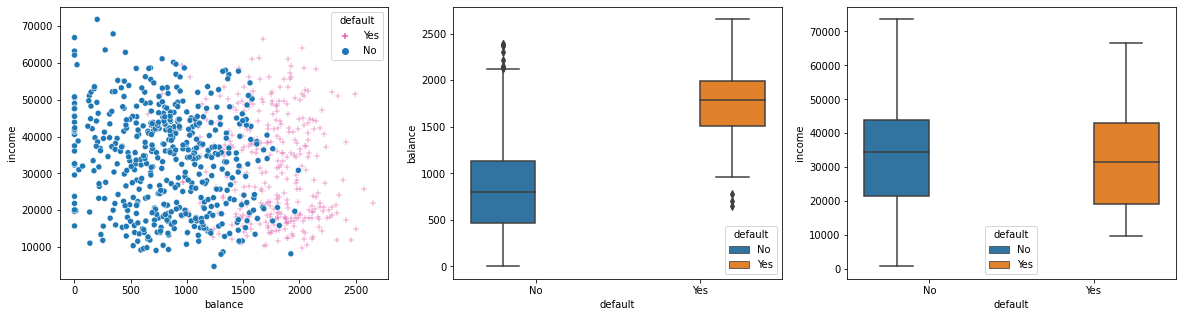

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# scatter plot of defaults against balance and income on a subset of samples
sns.scatterplot(ax=ax[0], x="balance", y="income", hue="default", data=df[df["default"]=="Yes"],  style="default", markers=['+'], palette="PuRd")
sns.scatterplot(ax=ax[0], x="balance", y="income", hue="default", data=df[df["default"]=="No"].sample(n=500))

# box plots of balance and income grouped by default attribute
sns.boxplot(ax=ax[1], x="default", y="balance", hue="default", data=df)
sns.boxplot(ax=ax[2], x="default", y="income", hue="default", data=df)

Some observations from the above plots:
-  _balance_ seems to separate defaulters from non-defaulters while *income* is not a discriminating attribute. 
- Defaulters tend to hold higher balances, higher than the median balance of non-defaulters, except for a very few cases.
- Income range of both defaulters and non-defaulters are similar

Let's also see how many defaulters and how many non-defaulters are there in the dataset.

In [ ]:
# df.groupby("default").count() # this also works but the one below just gives what we want
df["default"].value_counts()

No     9667
Yes     333
Name: default, dtype: int64

Only $3.33\%$ correspond to defaulters.



# Why not linear regression?
To start with, let us try to predict *default* variable using *balance*. The natural question is "why not linear regression for prediction?" There are a couple of reasons for preferring a classification method over linear regression:
They are:

1. Suppose the response variable has more than two categories - for example, consider a response variable like *weather* which has three categories $\{ \text{cold, } \text{rainy, } \text{pleasant}\}$. We have to encode it as numbers before applying linear regression. If we encode them as $0, 1, 2$, in order, then it induces an order for the three categories, saying that $\text{rainy}$ is equally distant from both $\text{cold}$ and $\text{pleasant}$, which may not be the case. Further, if we change the encoding to $1, 0, 2$, in order, for the three categories, then linear regression will produce different results.

2. In case of binary response variable like the *default* variable, we can encode using $0$ and $1$. However, linear regression will produce continuous outputs. How do we intrepret them? We can assume that the ouput produced for an input is the probability of response being $1$ for the given input. Subsequently, we can discretize the output to $1$ if this probability is $\gt \theta$;  else $0$, where $\theta$ is a threshold. In the code below, we have fitted a linear regression model  to predict *default* using the predictor *balance*. We can see that some of the response values are negative. This is the problem with linear regression when we directly model the discrete response using a linear model. If we try to intrepret the outputs produced by the linear model as probabilities, then we get probabilities which are negative. We may also get outputs which are greater then $1$. These kind of outputs are not valid to be intrepreted as probabilities. For them to be intrepreted as probabilities, they should be in the range $[0, 1]$. 

Intercept a: -0.08
slope b: 0.00


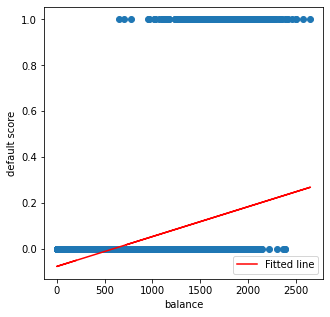

In [ ]:
import numpy as np
from sklearn import linear_model
ccdf1 = df.loc[:, ["balance", "default"]]
ccdf1["default"] = np.where(ccdf1["default"].str.contains("Yes"), 1, 0)

lin_reg = linear_model.LinearRegression() # instantiate linear reg object from linear_model module
x = np.array(ccdf1["balance"])[:, None] # prepare data; x is nsamples x nfeatures; 
y = np.array(ccdf1["default"]) # y is the response
lin_reg.fit(X=x, y=y) # fit the model to the data
print(f"Intercept a: {lin_reg.intercept_:.2f}\nslope b: {lin_reg.coef_[0]:.2f}") # extract and print the intercept and coeffcients 

# predict the fitted model on training data 
y_hat = lin_reg.predict(x)

# visulaize
plt.figure(figsize=(5, 5))
plt.scatter(x, y)
plt.plot(x, y_hat, color='r', label='Fitted line')
plt.xlabel('balance')
plt.ylabel('default score')
plt.legend()


# Logistic regression
We will focus on binary classification. Since linear regression model produces outputs which may not be contained in $[0, 1]$, we can map those outputs to $[0, 1]$. There are many functions which does that. One such function is the logistic or sigmoid function given below: $$\sigma(x) = \frac{1}{1+e^{-x}} \tag{1} $$ where $x \in R$. The plot of this function and its derivative is shown below. Note that $\sigma$ is an S-shaped curve that saturates for extreme values of $x$ (in fact, it starts almost saturating for $|x| \gt 3$). At $0$, it takes the value $0.5$. It's derivative, which can be derived to be $\sigma*(1-\sigma)$ has a maximum value of $0.25$ at $0$.

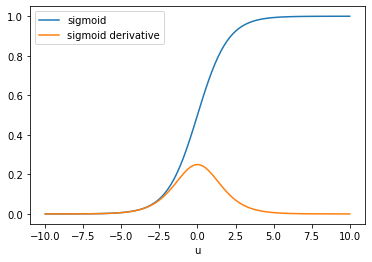

In [ ]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

u = np.linspace(-10, 10, 100) 
v = sigmoid(x)
plt.plot(u, v, label="sigmoid") 
plt.plot(u, v*(1-v), label="sigmoid derivative") # derivative of sigmoid is product of itself * (1-itself) i.e y*(1-y)
plt.xlabel("u") 
plt.legend()

Using sigmoid function, we map the output of the affine combination of $x_1, ..., x_p$ to $[0, 1]$ as $\sigma(a+b_1x_1+b_2x_2+...+b_px_p)$. Now, the intrepretation that $\sigma(a+b_1x_1+b_2x_2+...+b_px_p)$ is the probability of the response $y$ being $1$ for the given input $x$ is a valid one. We denote this as: $$p = P(y=1|x) = \sigma(a+b_1x_1+b_2x_2+...+b_px_p)$$ 

Obviously, $P(y=0|x)=1-p$. 

Note that $$p=\frac {1}{1+e^{-(a+b^Tx)}} \tag{2}$$ where $b^Tx = b_1x_1+b_2x_2+...+b_px_p$

$\implies$ $$\frac{p}{1-p} = e^{a+b^Tx} \tag{3}$$

$\implies$ $$\ln(\frac{p}{1-p})=a+b^Tx \tag{4}$$

$\frac{p}{1-p}$ is called as odds whose range is $[0, \infty)$.

$\ln(\frac{p}{1-p})$ is called as log-odds or logit. So, we see that, in logistic regression, we fit linear regression to log-odds of probability of response instead of the response itself. 

Now, the cofficient $b_i$ denotes the change in logit for one unit change in $x_i$, keeping all other $x_j$'s fixed. This is equivalent to odds multiplied by the factor $e^{b_i}$. Note that $p=\frac{odds}{odds+1}$. So, a unit change in $x_i$, keeping all other $x_j$'s fixed will non-linearly affect $p$. This is clear from the plots of sigmoid and its derivative given above.

All well. Now, how do we estimate the coefficients $a, b_1, b_2, ..., b_p$. Can we  directly use one of the linear regression tools we have seen in the previous notes in equation $(4)$? No, because we need access to $P(y=1|x)$ whereas we have access only to $y$. If we simply assume that $y=1$ implies that  $P(y=1|x)=1$ and $y=0$ implies that  $P(y=1|x)=0$ i.e in the given data, labels correspond to "no uncertainities" in the categories of inputs, then log-odds will be $\infty$ or $-\infty$, respectively. This will not help. So, we need alternatives to estimate the coefficients $a, b_1, b_2, ..., b_p$. There are two alternatives viz. maximum likelihood approach (MLE) and iterative weighted least squares (IWLS). We will look at only MLE in this notes.

But, even before looking at MLE, another doubt may linger in our minds
The doubt is that why do we need equation (4). Why not (i) fit linear regression directly on the given samples, which will gives us the coefficients, (ii) then apply sigmoid to linear regression outputs, which will give us values in [0, 1], (iii) intrepret the values as probabilities and threshold at say, $0.5$ to decide among two classes. Lets try this for the linear regression fit we have done above.

max probability: 0.481	min probability: 0.567

Training accuracy with prob threshold at 0.5: 0.3456
Training accuracy with prob threshold at 0.54: 0.9701
Training accuracy with prob threshold at 0.56: 0.9672



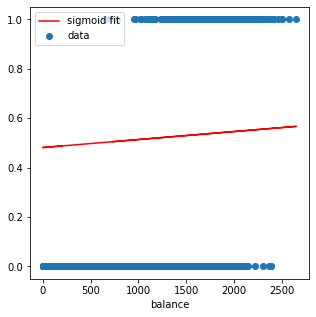

In [ ]:
# we already have y_hat from linear regression; we will map them to [0, 1]
probs = sigmoid(y_hat)

# predict and compute accuracy at three different probability thresholds in the next three lines.
predictions1 = (probs>0.5) 
predictions2 = (probs>0.54)
predictions3 = (probs>0.56)
accuracy1 = np.sum(predictions1==y)/len(y)
accuracy2 = np.sum(predictions2==y)/len(y)
accuracy3 = np.sum(predictions3==y)/len(y)

print(f"max probability: {np.min(probs):.3f}\tmin probability: {np.max(probs):.3f}\n")
print(f"Training accuracy with prob threshold at 0.5: {accuracy1}")
print(f"Training accuracy with prob threshold at 0.54: {accuracy2}")
print(f"Training accuracy with prob threshold at 0.56: {accuracy3}\n")

# visualize
plt.figure(figsize=(5, 5))
plt.scatter(x, y, label="data")
plt.plot(x, probs, color='r', label="sigmoid fit")
plt.xlabel('balance')
plt.legend()

We see that the overall accuracy on the trainining data itself is very low ($34.56\%$). The reason is that directly mapping the linear regression outputs to $[0, 1]$ using sigmoid may not cover the range $[0, 1]$ well. In fact the mapping is into the middle linear part of the sigmoid. Entire set of $10000$ linear regression outputs got mapped to a narrow range of $[0.481, 0.567]$. Thresholding in this narrow range with $0.5$ as threshold resulted in low accuracy. Increasing the threshold to certain extent increases the accuracy. Once the limit is crossed, the accuracy comes down. Accuracies with different thresholds are printed above. Determining the appropriate threshold and attaching an intuitive meaning is not easy here. We would like to fit a sigmoid curve in such a way that data belonging to one class hugs on to the top flat part of sigmoid while the other hugs onto the bottom flat part of the sigmoid. This way range $[0, 1]$ is well covered and thresholding at $0.5$ makes sense.

There is also another reason why we may not convert linear regression outputs to probabilities and use them for classification. Let us see this. Suppose we want to classify a tumor benign or malignant based on its size. Let us say that smaller sizes are generally benign while bigger ones are malignant. Let's create a toy dataset simulating this and use linear regression for classification.

Intercept a: -0.22
slope b: 0.01
max probability: 0.445	min probability: 0.772

Training accuracy with prob threshold at 0.5: 0.69



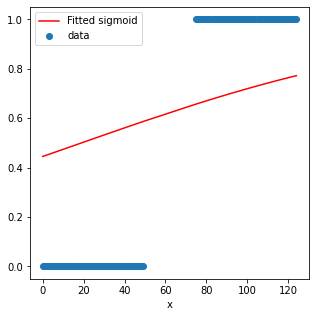

In [ ]:
x = np.array(list(range(50)) + list(range(75, 125))).reshape(-1, 1)
y = np.hstack((np.zeros(50), np.ones(50)))

lin_reg.fit(X=x, y=y) # fit the model to the data
print(f"Intercept a: {lin_reg.intercept_:.2f}\nslope b: {lin_reg.coef_[0]:.2f}") # extract and print the intercept and coeffcients 

# predict the fitted model on training data 
y_hat = lin_reg.predict(x)
probs = sigmoid(y_hat)
predictions = (probs>0.5)

# training accuracy
accuracy = np.sum(predictions==y)/len(y)
print(f"max probability: {np.min(probs):.3f}\tmin probability: {np.max(probs):.3f}\n")
print(f"Training accuracy with prob threshold at 0.5: {accuracy}\n")

#visualize
plt.figure(figsize=(5, 5))
plt.scatter(x, y, label="data")
plt.plot(x, probs, color='r', label='Fitted sigmoid')
plt.xlabel('x')
plt.legend()

Suppose the malignant cases had two different range of sizes in the data - one in $[75, 100]$ and the other in $[400, 425]$. We can see in the plot below how the fit (red color) got pulled towards data in the range $[400, 425]$ (remember high leverage points from the last notes!!) compared to the previous fit (green color). This resulted in the probability range $[0.551, 0.754]$. This range is $\gt 0.5$ and so all the samples are classified as malignant, resulting in accuracy of $0.5$. A logistic regression model would not behave like this. In logistic regression, we do not independantly determine coefficients, and then convert them to probabilities. Instead, we determine the appropriate coefficients that will push the predicted probabilities closer to the expected ones.

Intercept a: 0.20
slope b: 0.00
max probability: 0.551	min probability: 0.754

Training accuracy with prob threshold at 0.5: 0.5



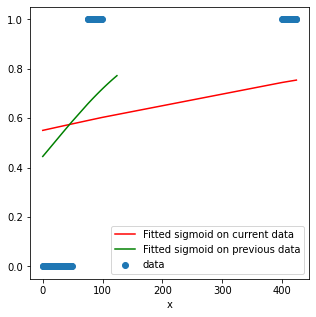

In [ ]:
x1 = np.array(list(range(50)) + list(range(75, 100)) + list(range(400, 425))).reshape(-1, 1)
y1 = np.hstack((np.zeros(50), np.ones(50)))

lin_reg.fit(X=x1, y=y1) # fit the model to the data
print(f"Intercept a: {lin_reg.intercept_:.2f}\nslope b: {lin_reg.coef_[0]:.2f}") # extract and print the intercept and coeffcients 

# predict the fitted model on training data 
y_hat1 = lin_reg.predict(x1)
probs1 = sigmoid(y_hat1)
predictions = (probs1>0.5)

#accuracy on training data
accuracy = np.sum(predictions==y1)/len(y1)
print(f"max probability: {np.min(probs1):.3f}\tmin probability: {np.max(probs1):.3f}\n")
print(f"Training accuracy with prob threshold at 0.5: {accuracy}\n")

#visualize
plt.figure(figsize=(5, 5))
plt.scatter(x1, y1, label="data")
plt.plot(x1, probs1, color='r', label='Fitted sigmoid on current data')
plt.plot(x, probs, color='g', label='Fitted sigmoid on previous data')
plt.xlabel('x')
plt.xlabel('x')
plt.legend()

## MLE for logistic regression
Let the training data be $\{(x^i, y^i)\}_{i=1,2,...n}$. We model the response $y^i$ for a given $x^i$ as a Bernoulli random variable. It takes value $1$ with probability $p^i$ and $0$ with probability $1-p^i$ i.e $P(y^i=1|x^i)=p^i$ and $P(y^i=0|x^i)=1-p^i$.  Note that equation $(2)$ gives the form of $p^i$'s, which are dependant on the coefficients. Assuming independance of samples, we form the likelihood function $$L(a, b_1, ..., b_p|(x^1, y^1), ..., (x^n, y^n)) = \prod_{i=1}^{n} P(x^i, y^i|a, b_1, ..., b_p)$$ where $P(x^i, y^i|a, b_1, ..., b_p)$ is the joint probability of observing $x^i$ and $y^i$ together when the coefficients are $a, b_1, ..., b_p$. This can be simplified as $$L(a, b_1, ..., b_p|(x^1, y^1), ..., (x^n, y^n)) = \prod_{i=1}^{n} P(y^i|x^i, a, b_1, ..., b_p) P(x^i|a, b_1, ..., b_p)$$ Since $x^i$'s are not dependant on $a, b_1, ..., b_p$ and since $P(y^i=1|x^i)=p^i$, the last equation  is equivalent to $$L(a, b_1, ..., b_p|(x^1, y^1), ..., (x^n, y^n)) = \prod_{i:y^i=1}{p^iP(x^i)} \prod_{i:y^i=0}{(1-p^i)P(x^i)} \tag{5}$$ 

For convenience, we denote lhs in equation (5) by $L(a, b)$. $L(a, b)$ spells out the joint probability or likelihood of observing the training data when the coefficients are $a, b$.  What should be the appropriate values for $a, b?$ According to MLE principle, the appropriate values of $a, b$ denoted by $\hat{a}, \hat{b}$ should be such that the likelihood is maximized. i.e $$ \hat a, \hat b = \underset{a, b}{\mathrm{argmax}} \hspace{.1 cm} L(a, b)$$ Since $P(x^i)$ is independant of $a, b$, the maximization is equivalent to $$\hat a, \hat b = \underset{a, b}{\mathrm{argmax}} \hspace{.1 cm} \prod_{i:y^i=1}{p^i} \prod_{i:y^i=0}{(1-p^i)} $$ This is equivalent to $$\hat a, \hat b = \underset{a, b}{\mathrm{argmax}} \hspace{.1 cm} \prod_{i=1}^{n}{(p^i)}^{y^i} {(1-p^i)^{1-y^i}} $$Since $p^i$'s are in $[0, 1]$, and so the product of many $p^i $'s and $1-p^i$'s can become very small which may result in instability when the maximization is numerically solved, we use $log$  and convert the product to sum. Since $log$ is monotonic, maximization is not affected. Hence the maximization problem transforms to $$\hat a, \hat b = \underset{a, b}{\mathrm{argmax}} \hspace{.1 cm} \sum_{i=1}^{n}{y^i}\ln{p^i}+{(1-y^i)}\ln{(1-p^i)} \tag{6}$$ The summation in equation (6) is called as log-likelihood. Instead of maximizing log-likelihood, we can as well minimize the negative log-likelihood (NLL). NLL is also called as cross-entropy (CE), though in binary classfication problems, NLL is the preferred word while in multi-class setting, CE is preferred.

Unlike linear regression, the minimization of NLL does not have a closed form solution. We have to solve it numerically using methods like gradient descent or LBFGS. Of course, we will rely on software package as shown in the code below where we fit logistic regression model to predict *default* from *balance*. 

In [ ]:
import statsmodels.discrete.discrete_model as smd
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

#training data
X = ccdf1["balance"]
X = sm.add_constant(X) # prepend a column of 1's for intercept
y = ccdf1["default"]

log_reg = smd.Logit(endog=y, exog=X) # instantiate logistic regression model from statsmodels package
results = log_reg.fit() # fit the model to the data

# display results
temp_dict = {"val":np.around(results.params.values, decimals=3), 
             'SE':np.around(results.bse.values, decimals=3), 
             't-statistic':np.around(results.tvalues.values, decimals=3), 
             '95% CI':list(np.around(results.conf_int().values, decimals=3)), 
             'p-value':np.around(results.pvalues.values, decimals=3)}
log_reg_df = pd.DataFrame.from_dict(temp_dict)
log_reg_df.index=['a', 'b']
log_reg_df.index.name = 'coeff'
print("\n", log_reg_df)

Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10

           val     SE  t-statistic             95% CI  p-value
coeff                                                        
a     -10.651  0.361      -29.491  [-11.359, -9.943]      0.0
b       0.005  0.000       24.952     [0.005, 0.006]      0.0


The results above suggest that *default* depends on *balance*. 



## Prediction
Now, let's compute the training accuracy of the model.

In [ ]:
predicted_probs = log_reg.predict(results.params, X)
predicted_responses = predicted_probs > 0.5
training_acc = np.sum(y==predicted_responses) / len(X)
print(f"Training accuracy:\t{training_acc*100:.2f}%")

Training accuracy:	97.25%


Let us also look at the decision boundary produced by the model. Note that decision boundary is the hypersurface that separates classes. Here, the two classes are separated based on whether the probability $p \gt 0.5$ or not. So, $p = 0.5$ gives the decision boundary. This is equivalent to $\sigma(a+b^Tx)=0.5$, which is same as saying $a+b^Tx=0$. The decision boundary and the probability curve are plotted below for our example.

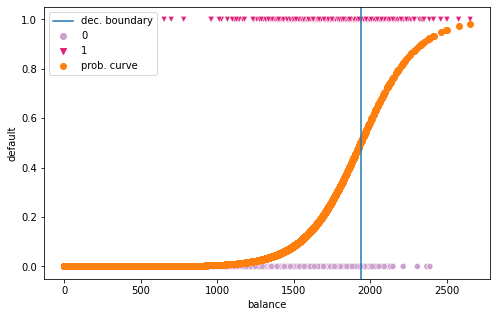

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x="balance", y="default", hue="default", data=ccdf1,  style="default", markers=['o', 'v'], palette="PuRd")
a, b = results.params.values
plt.axvline(x=-a/b, label="dec. boundary")
plt.scatter(ccdf1["balance"], predicted_probs, label="prob. curve")
plt.legend()

From the decision boundary, it is clear that the model mispredicts badly on defaulters. However, we saw that the training accuracy of the model is $97.25\%$. The reason for such high accuracy is because the dataset is imbalanced. We saw that only $3\%$ of the data belongs to defaulters. The accuracies on each class (also called sensitivity and specificity, see the next section on performance measures) is shown below.

In [ ]:
# data for class 1
X_1 = ccdf1[ccdf1["default"]==1]["balance"]
X_1 = sm.add_constant(X_1)
y_1 = ccdf1[ccdf1["default"]==1]["default"]

# data for class 0
X_0 = ccdf1[ccdf1["default"]==0]["balance"]
X_0 = sm.add_constant(X_0)
y_0 = ccdf1[ccdf1["default"]==0]["default"]

# accuracies for each class
predicted_probs_1 = log_reg.predict(results.params, X_1)
predicted_probs_0 = log_reg.predict(results.params, X_0)
predicted_responses_1 = predicted_probs_1 > 0.5
predicted_responses_0 = predicted_probs_0 > 0.5
training_acc_1 = np.sum(y_1==predicted_responses_1) / len(X_1)
training_acc_0 = np.sum(y_0==predicted_responses_0) / len(X_0)
print(f"Training accuracy for class 1:\t{training_acc_1*100:.2f}%")
print(f"Training accuracy for class 0:\t{training_acc_0*100:.2f}%")

Training accuracy for class 1:	30.03%
Training accuracy for class 0:	99.57%


## Performance measures
We can use confusion matrix $C$ to look at performance of the model on individual classes. A confusion matrix for a $k$ classes problem is a $k \times k$ matrix. Rows correspond to true labels. Columns correspond to predicted labels. $C[i, j]$ denotes the number of times (or in some packages, proportion of times) true label $i$ is predicted as $j$ by the model. So, elements along diagonal provide correct classification information and elements off the diagonal provide misclassification information. The code below obtains the confusion matrix for our example.

In [ ]:
C = results.pred_table(threshold=0.5) # confusion matrix

# some extra code for decent display of the confusion matrix
rows = [("True", 0), ("True", 1)]
rows = pd.MultiIndex.from_tuples(rows)
columns = pd.MultiIndex.from_product([["Predicted"], [0, 1]])
C_df = pd.DataFrame(data=C, index=rows, columns=columns)
C_df["Total"] = C_df.sum(axis=1)
C_df.loc["Total"] = C_df.sum(axis=0)
print(C_df)

          Predicted           Total
                  0      1         
(True, 0)    9625.0   42.0   9667.0
(True, 1)     233.0  100.0    333.0
Total        9858.0  142.0  10000.0


We will now focus on binary classification. For the credit card default example, let us call defaulters as positive class and non-defaulters as negative class. 
- *Overall accuracy* (also called *accuracy*) is the ratio between number of correct predictions and total number of predictions. From $C$, this can be computed as $\frac{C[0, 0]+C[1, 1]}{C[0, 0]+C[0, 1]+C[1, 0]+C[1, 1]}\%$. For the credit card example, the *accuracy* turned out to be $97.25\%$. 
- We define *sensitivity* (also called *recall* or *true positive rate* or *TPR*) as the rate of true positives correctly predicted by the model. This corresponds to $\frac{C[1, 1]}{C[1, 0]+C[1,1]}$ in the confusion matrix $C$, which is $0.3003$. 
- *Specificity* (also called *true negative rate* or *TNR*) is the rate of true negatives correctly predicted by the model. This corresponds to $\frac{C[0, 0]}{C[0, 0]+C[0,1]}$, which is $0.9957$. 
- $1-specificity$ is called as *false postive rate (FPR)*, which is the rate of true negatives predicted as positives. In our example *FPR* is $0.0043$. 
- *Precision* (also called as *positive predictive value* or *PPV*) is the the rate of correctly predicted positives among all predicted positives. This corresponds to $\frac{C[1, 1]}{C[0, 1]+C[1,1]}$, which is $0.7042$. 
- *F-measure* (also called *F1-measure*) is the harmonic mean of *precision* and *recall*. It can be computed as $\frac{2*precision*recall}{precision+recall}$. It ranges in $[0, 1]$, with high value close to $1$ indicating good *precision* and *recall*, and low value close to $0$ indicating poor *precision* and *recall*. 

When data is imbalanced (as is our case here), *precision* or *recall* cannot by themselves individually reveal the model's performance on the positive class. For example, suppose in a dataset with $100$ true positives, say the model predicted $10$ samples as positives. Suppose these $10$ samples also have true labels as positives. Then *precision* is $1.0$ while *recall* is only $0.1$. We cannot just conclude based on precision that the model is doing very well. Similarly we can have a scenario where *recall* is very high but *precision* is very low. For example, in a dataset with $100$ true positives and $900$ true negatives, the model predicted $600$ samples as positives. Suppose these $600$ samples contain all the $100$ samples whose true labels are positive. Then the *recall* is $1.0$ while the *precision* is only $0.17$. We cannot just conclude based on *recall* that the model is doing very well. In these kind of scenarios, *F-measure* is suitable. For our example, *F-measure* is $0.42$. 

 




## ROC curve
Having defined various performance measures, let us look at the credit card default problem again. The credit card company will be more interested in risky customers being correctly identified (high *recall*) than missing out on some non-risky customers (relatively low *precision* or high *FPR*). Currently, *recall* rate is very low ($30.03\%$). How do we improve the recall rate of the model? Note that we classified a sample to be a defaulter (positive class) only when the probability of being a defaulter given the sample was $\gt 0.5$. Let us call this probability value as probability threshold. If we reduce this probability threshold, we can improve the *recall* rate. This is shown in the plot below. As the probability threshold decreases, the proportion of risky customers identified correctly increases (i.e the false negative rate *FNR* decreases which in turn implies *recall* increases because $1-FNR$ is *recall*). However, the number of non-risky customers being missed out increases (i.e *FPR* increases), and the overall error rate also increases.





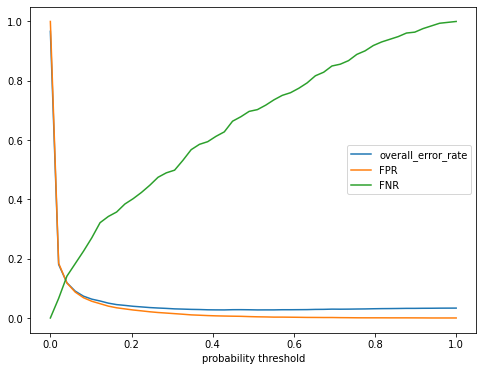

In [ ]:
prob_threshold = np.linspace(0., 1.)
overall_error_rate = []
FPR = []
FNR = []
for pt in prob_threshold:
  C = results.pred_table(threshold=pt)
  training_acc = (C[0, 0] + C[1, 1]) / len(X)
  overall_error_rate.append(1. - training_acc)
  specificity = C[0, 0] / (C[0, 0] + C[0, 1])
  recall = C[1, 1] / (C[1, 0] + C[1, 1])
  FPR.append(1. - specificity)
  FNR.append(1. - recall)

plt.figure(figsize=(8, 6))
plt.plot(prob_threshold, overall_error_rate, label="overall_error_rate")
plt.plot(prob_threshold, FPR, label="FPR")
plt.plot(prob_threshold, FNR, label="FNR")
plt.xlabel("probability threshold")
plt.legend()

How can we identify the best probability threshold value? Domain knowledge (like how much loss the credit card company incurs with risky customers) can help in choosing the threshold. Another way is to plot receiver operating characteristic (ROC) curve. It plots *FPR* in $x$-axis against *TPR* in $y$-axis over all possible thresholds. The thresholds are not explicit in the plot. They are implicit in that each point *(FPR, TPR)* on the curve corresponds to a threshold. The area under the curve (AUC) summarises the overall performance of the classifier. Note that the curve is monotonically non-decreasing and it's shape will be like upside down L. An ideal classifier will have a perfect upside down L with the point $(FPR=0.0, TPR=1.0)$ lying on the curve. For our example, the ROC curve is shown below.

Coefficients
------------
a	-10.651
b	0.005

Accuracy: 0.973
Error rate: 0.027
Precision: 0.704
Recall: 0.300
f1_score: 0.421


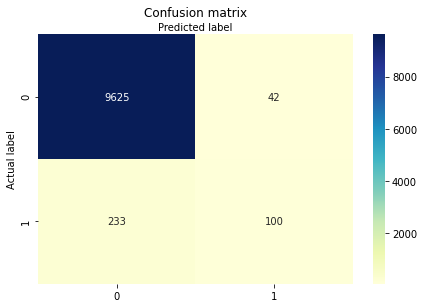

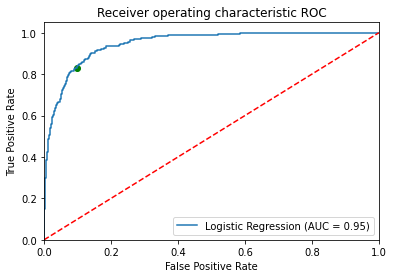

In [ ]:
# we have been fitting logistic regression model using stasmodels package until now
# we will use sklearn package now
# statsmodels gives you all statistics related to the model fit
# For errors and metrics related to classifier's performance, sklearn is better

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
np.printoptions(precision=3)

X = np.array(ccdf1["balance"]).reshape(-1, 1) #sklearn's LogisticRegression requires data in nsamples x features form
y = np.array(ccdf1["default"])
log_reg = LogisticRegression(penalty='none', fit_intercept=True)  #instantiate sklearn's logistic regression model
log_reg.fit(X, y) # fit the model to the data
y_pred = log_reg.predict(X) # predict on training data

print(f"Coefficients\n------------\na\t{log_reg.intercept_.item():.3f}\nb\t{log_reg.coef_[0].item():.3f}\n")

print('Accuracy: {:.3f}'.format(accuracy_score(y, y_pred)))
print('Error rate: {:.3f}'.format(1 - accuracy_score(y, y_pred)))
print('Precision: {:.3f}'.format(precision_score(y, y_pred)))
print('Recall: {:.3f}'.format(recall_score(y, y_pred)))
print('f1_score: {:.3f}'.format(f1_score(y, y_pred)))

# compute and plot confusion matrix
C = confusion_matrix(y, y_pred)
fig, ax = plt.subplots()
class_names=[0,1]
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(C), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# ROC curve
logit_roc_auc = roc_auc_score(y, log_reg.predict_proba(X)[:, 1])
fpr, tpr, thresholds = roc_curve(y, log_reg.predict_proba(X)[:, 1])

#visualize ROC curve
operating_point_index = np.where(np.isclose(np.around(thresholds, decimals=2), 0.05) == True)[0][0]
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.scatter(fpr[operating_point_index], tpr[operating_point_index], c="green")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ROC')
plt.legend(loc="lower right")


The red line in the second graph above is the ROC curve of the random classifier that chooses class 0 or 1 based on the toss of a fair coin. It has AUC=$0.5$. The farther the ROC curve of the logistic regression classifier above the red line, the better its overall performance across all possible thresholds. This is quantified by AUC which is 0.95 for our example. The ideal ROC curve will have AUC=$1.0$. 

Suppose the credit card company is conservative and fixes the probability threshold as $.05$. This corresponds to the green point in the ROC curve. This point corresponds to a *recall* of just above $80\%$ with false postive percentage to be around $10\%$. By reducing the threshold further, *recall* can be increased.

One point to keep in mind is that all our analysis has been on the training set only. However, we build ML models to test its performance on new data, assuming that they come from the same distribution as the training data. We will come to this soon in the next set of notes. 

## Multivariate logistic regression
We will now predict *default* using all the input attributes by fitting a multivariate logistic regression model. See the code below.

In [ ]:
#training data
ccdf2 = df.copy()
ccdf2["default"] = np.where(ccdf2["default"].str.contains("Yes"), 1, 0) # convert default to numeric attribute
ccdf2["student"] = np.where(ccdf2["student"].str.contains("Yes"), 1, 0) # convert student to numeric attribute

X = ccdf2.drop("default", axis=1) # predictors
X = sm.add_constant(X) # prepend a column of 1's for intercept
y = ccdf2["default"] # response

multi_log_reg = smd.Logit(endog=y, exog=X)
results = multi_log_reg.fit()

temp_dict = {"val":np.around(results.params.values, decimals=3), 
             'SE':np.around(results.bse.values, decimals=3), 
             't-statistic':np.around(results.tvalues.values, decimals=3), 
             '95% CI':list(np.around(results.conf_int().values, decimals=3)), 
             'p-value':np.around(results.pvalues.values, decimals=3)}
multi_log_reg_df = pd.DataFrame.from_dict(temp_dict)
multi_log_reg_df.index=['a', 'b1', 'b2', 'b3'] # b1 corresponds to student, b2 corresonds to balance, b3 corresponds to income
multi_log_reg_df.index.name = 'coeff'
print("\n", multi_log_reg_df)

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10

           val     SE  t-statistic             95% CI  p-value
coeff                                                        
a     -10.869  0.492      -22.079  [-11.834, -9.904]    0.000
b1     -0.647  0.236       -2.738    [-1.11, -0.184]    0.006
b2      0.006  0.000       24.737     [0.005, 0.006]    0.000
b3      0.000  0.000        0.370        [-0.0, 0.0]    0.712


It is clear from the above results that *balance* and *student* influence *default* while *income* does not play any role. Note that the coefficient associated with *student* ($b_1$) is negative. This means that students are less likely to default given a particular *balance* value and *income* value. Since *income* is insignificant, the above statement is same as saying that students are less risky than non-students with same credit card balance.

Prediction accuracy of the multivariate model is computed in the code below. We can see that accuracy on the defaulters class has slightly increased. Predicted probabilities are also plotted.



In [ ]:
predicted_probs = multi_log_reg.predict(results.params, X)
predicted_responses = predicted_probs > 0.5
training_acc = np.sum(y==predicted_responses) / len(X)
print(f"Overall training accuracy:\t{training_acc*100:.2f}%")

X_1 = ccdf2[ccdf2["default"]==1].loc[:, ["student", "balance", "income"]]
X_1 = sm.add_constant(X_1)
y_1 = ccdf2[ccdf2["default"]==1]["default"]

X_0 = ccdf2[ccdf2["default"]==0].loc[:, ["student", "balance", "income"]]
X_0 = sm.add_constant(X_0)
y_0 = ccdf2[ccdf2["default"]==0]["default"]

predicted_probs_1 = multi_log_reg.predict(results.params, X_1)
predicted_probs_0 = multi_log_reg.predict(results.params, X_0)
predicted_responses_1 = predicted_probs_1 > 0.5
predicted_responses_0 = predicted_probs_0 > 0.5
training_acc_1 = np.sum(y_1==predicted_responses_1) / len(X_1)
training_acc_0 = np.sum(y_0==predicted_responses_0) / len(X_0)
print(f"Training accuracy for class 1:\t{training_acc_1*100:.2f}%")
print(f"Training accuracy for class 0:\t{training_acc_0*100:.2f}%")

Overall training accuracy:	97.32%
Training accuracy for class 1:	31.53%
Training accuracy for class 0:	99.59%


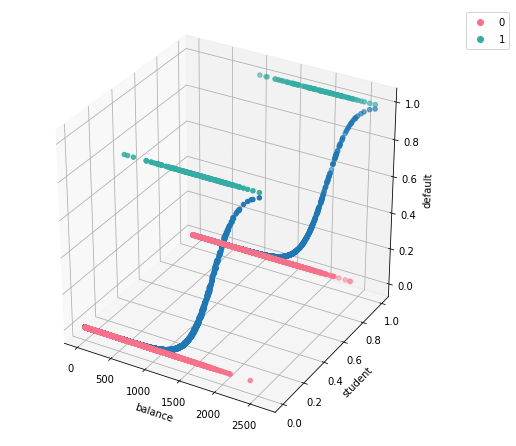

In [ ]:
# plotting the predicted probabilities
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
cmap = ListedColormap(sns.color_palette("husl", 2).as_hex())
sc = ax.scatter(ccdf2["balance"], ccdf2["student"], ccdf2["default"], c=ccdf2["default"], cmap=cmap)
ax.scatter(ccdf2["balance"], ccdf2["student"], predicted_probs)
ax.set_xlabel("balance")
ax.set_ylabel("student")
ax.set_zlabel("default")
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

Suppose we want to answer the question - who is risky overall, students or non-students? To answer this question, we should not consider *balance* and *income* in our model. The code below predicts *default* based on only *student*.

In [ ]:
#training data
ccdf3 = df.copy()
ccdf3["student"] = np.where(ccdf3["student"].str.contains("Yes"), 1, 0)
ccdf3["default"] = np.where(ccdf3["default"].str.contains("Yes"), 1, 0)
X = ccdf3["student"]
X = sm.add_constant(X) # prepend a column of 1's for intercept
y = ccdf3["default"]

log_reg_student = smd.Logit(endog=y, exog=X)
results = log_reg_student.fit()
temp_dict = {"val":np.around(results.params.values, decimals=3), 
             'SE':np.around(results.bse.values, decimals=3), 
             't-statistic':np.around(results.tvalues.values, decimals=3), 
             '95% CI':list(np.around(results.conf_int().values, decimals=3)), 
             'p-value':np.around(results.pvalues.values, decimals=3)}
log_reg_student_df = pd.DataFrame.from_dict(temp_dict)
log_reg_student_df.index=['a', 'b']
log_reg_student_df.index.name = 'coeff'
print("\n", log_reg_student_df)

Optimization terminated successfully.
         Current function value: 0.145434
         Iterations 7

          val     SE  t-statistic            95% CI  p-value
coeff                                                      
a     -3.504  0.071      -49.554  [-3.643, -3.366]      0.0
b      0.405  0.115        3.520     [0.179, 0.63]      0.0


We see now that, overall, students are riskier than non-students (the coefficient $b$ associated with *student* is positive now and statistically significant). How do we understand this behaviour with the opposite behaviour we saw in the multivariate case? We can refer back to the previous notes on linear regression wherein we had different behaviour of a predictor in single and multivariate case. The reason there was the correlation between the two predictors. That should drive us to see if *student* is correlated with any other predictor. Since *income* is anyway not significant, we can look at the relationship between *student* and *balance*. This is shown in the boxplot below. Clearly, students maintain higher balance than non-students. We already know that higher balance is more likely to result in *default=Yes*. This is why overall students are more riskier than non-students. However, as we saw in the multivariate case, for a fixed credit card balance, students are less riskier than non-students. This is depicted in the right side plot below.

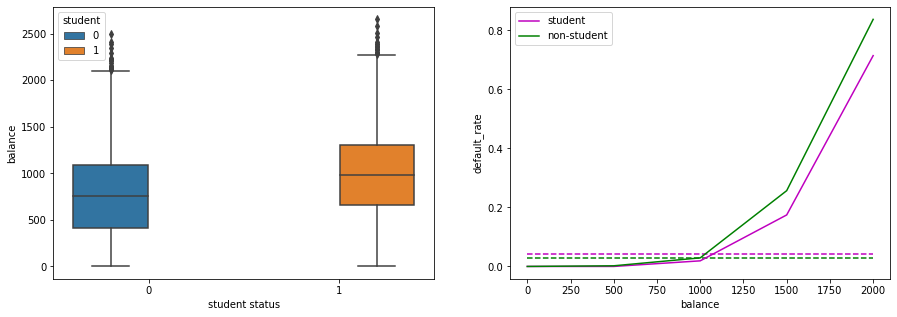

In [ ]:
# function to compute default rates of students and non_students
def default_rate(df):
  students = df.loc[df["student"]==1]
  non_students = df.loc[ccdf2["student"]==0]
  overall_default_rate_students = students["default"].sum()/len(students)
  overall_default_rate_non_students = non_students["default"].sum()/len(non_students)
  return pd.Series([overall_default_rate_students, overall_default_rate_non_students])

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(ax=ax[0], x="student", y="balance", hue="student", data=ccdf2)
ax[0].set_xlabel("student status")
ax[0].set_ylabel("balance")

bins = np.array([0., 500., 1000., 1500., 2000.])
default_rates = default_rate(ccdf2)
ax[1].plot(bins, np.tile(default_rates[0], 5), 'm--')
ax[1].plot(bins, np.tile(default_rates[1], 5), 'g--')
groups=ccdf2.groupby(np.digitize(ccdf2.balance, bins))
default_rates_groupwise = groups.apply(default_rate)
ax[1].plot(bins, default_rates_groupwise.loc[:, 0] , 'm-', label="student")
ax[1].plot(bins, default_rates_groupwise.loc[:, 1] , 'g-', label="non-student")
ax[1].set_xlabel("balance")
ax[1].set_ylabel("default_rate")
ax[1].legend()

We will now plot the confusion matrix and ROC curve for the multivariate model. 

We can see from the plots below that there is not much improvement in performance with multivariate model.

**Caution**: Note that the results of statsmodels and sklearn may differ if data is not normalized. See [here](https://github.com/scikit-learn/scikit-learn/issues/19193). We will cover data normalization, a very important topic, soon.  This first set of notes is to give a flavour of two simple ML models. 

a: -10.865
b1: -0.648
b2: 0.006
b3: 0.000


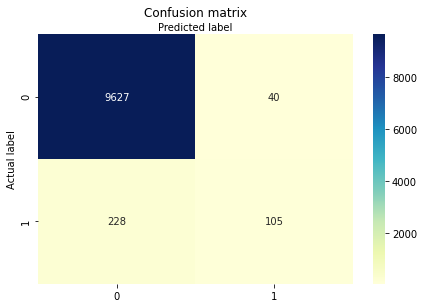

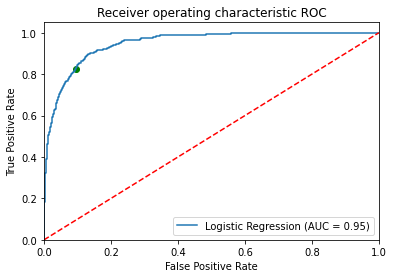

In [ ]:
X = ccdf2.drop("default", axis=1)
y = ccdf2["default"]
multi_log_reg = LogisticRegression(penalty='none', fit_intercept=True, solver='newton-cg', max_iter=150) # if newton-cg optimization is not used here, the results are not matching with statsmodels results
multi_log_reg.fit(X, y)
y_pred = multi_log_reg.predict(X)

print(f"a: {multi_log_reg.intercept_.item():.3f}\nb1: {multi_log_reg.coef_[0, 0]:.3f}\nb2: {multi_log_reg.coef_[0, 1]:.3f}\nb3: {multi_log_reg.coef_[0, 2]:.3f}")


C = confusion_matrix(y, y_pred)
fig, ax = plt.subplots()
class_names=[0, 1]
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(C), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# plot ROC curve
multi_logit_roc_auc = roc_auc_score(y, multi_log_reg.predict_proba(X)[:, 1])
fpr, tpr, thresholds = roc_curve(y, multi_log_reg.predict_proba(X)[:, 1])
operating_point_index = np.where(np.isclose(np.around(thresholds, decimals=2), 0.05) == True)[0][0]
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % multi_logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.scatter(fpr[operating_point_index], tpr[operating_point_index], c="green")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ROC')
plt.legend(loc="lower right")


Logistic regression is generally used for binary classification problem. For multi-class classification, better models are available. We will look at one such model called linear discriminant analysis (LDA) in the next notes. 

Note that, in logistic regression, if required, we can introduce non-linearity as we had done in linear regression. In this case we will fitting log-odds against a linear model (linear in the coefficients) that has non-linear attributes.

# Questions
1. Create/get a simple dataset that has one nominal attribute with 3 categories and one continuous attribute. Perform linear regression with two different niumerical orderings on the nominal attribute and compare the results.

2. Find a function other than sigmoid function which can map the real line to [0, 1]. 

3. Fit the logistic regression model to the tumor toy dataset and compare with the linear regression based classification results.

4. When is boxplot useful?

5. **Answer by hand calculation**: Suppose we have 2054 samples of individuals out of which 880 are men and the rest are women. Among men, 481 attend morning prayers. Among women 582 attend morning prayers. <br>
 (i) What is the proportion of men who attend morning prayers?<br>
 (ii) What is the proportion of women who attend morning prayers?<br>
 (iii) What is the The estimated odds of a man attending morning prayers?<br>
 (iv) Repeat question (iii) for women.<br>
 (v) What is the The estimated log-odds of a man attending morning prayers?<br>
 (vi) Repeat question (v) for women.<br>
 (vii) From the log-odds computed in questions (v) and (vi), estimate the intercept and slope coefficient in the logistic regression model of predicting if a given individual (man equals 1, woman equals 0) will attend morning prayer or not (attending morning prayer equals 1, not attending morning prayer equals 0).<br>
 (viii)From the estimated log-odds, compute odds ratio given by $\frac{odds_{man}}{odds_{woman}}$ and comment on who is more likely to attend morning prayers and by how much?